# Figure.1 California Current System and Model Domain

In [1]:
import numpy as np
import scipy
import xarray as xr
import cmocean as cmo
import matplotlib.pyplot as plt
from aviso_rossby_wave import skill_matrix, reverse_vector, build_h_matrix
from aviso_rossby_wave import forecast_ssh, inversion

## Starting Date

In [2]:
# day0, day1 = 335, 375
day0, day1 = 0, 40 # 2016-01-01
#day0, day1 = 31, 71 # 2016-02-01
time_range = (day1 - day0) * 2 # forecast time range
exp = 1 # R_over_P = K^-1

### Stratification paramters

## Subset 10 degree by 10 degree of ocean
### the aviso data is sampled at 5-day intervals

In [3]:
# lonidx_west, lonidx_east = 67, 107
# latidx_south, latidx_north = 22, 62
lonidx_west, lonidx_east  =  60, 102
latidx_south, latidx_north = 34, 74

In [4]:
avisso_ds = xr.open_dataset('./aviso_msla_ccs_1d.nc')
SSHA = avisso_ds.msla[latidx_south:latidx_north, lonidx_west:lonidx_east, :]
T_time = avisso_ds.time.data[:] * 86400 # in seconds
#T_time = avisso_ds.time.data[day0:] * 86400 # in seconds
# SSHA.shape

In [5]:
date_time = avisso_ds.date_time.data[day0:]
date_time[0]

numpy.datetime64('2016-01-01T00:00:00.000000000')

In [6]:
#ssha_time_mean = SSHA[:, :, day0:day0+time_range ].mean(axis = -1) # remove 80-day mean insead of multi-year mean (climatology)
ssha_time_mean = SSHA[:, :, : ].mean(axis = -1) # remove multi-year mean (climatology)

In [7]:
SSHA = SSHA - ssha_time_mean # remove 80-day mean  SSHA[day0 + day0 + 30].mean(axis = -1) 
SSHA_masked = np.ma.masked_invalid(SSHA)
ssha_mask = np.ma.getmask(SSHA_masked)

#### MSLA is the AVISO SSH anomalies to fit
#### Fit multiple days of SSH anomalies: day0 to day1

In [8]:
MSLA0 = SSHA_masked[:, :, day0:day1] #AVISO input 

In [9]:
lon, lat = (360 - avisso_ds.lon[lonidx_west:lonidx_east].data) * -1, avisso_ds.lat[latidx_south:latidx_north].data
# lon, lat 

In [10]:
dlon = lon - lon.mean()
dlat = lat - lat.mean()

In [11]:
SSH0 = avisso_ds.msla[:, :, day0]
SSHA0 = SSH0 - avisso_ds.msla[:,:,:].mean(axis = -1)

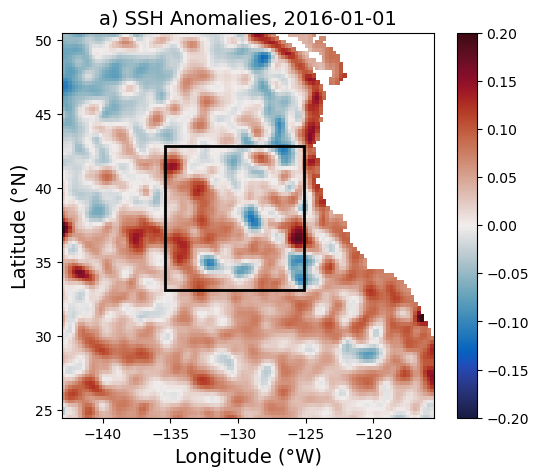

In [12]:
plt.figure(figsize = (6, 5))
# plt.subplot(121)
plt.title('a) SSH Anomalies, ' + str(date_time[0])[:10], fontsize = 14)
plt.pcolor((360 - avisso_ds.lon[30:140]) * -1, avisso_ds.lat, SSHA0[:, 30:140], vmin = -0.2, vmax = .2, cmap = cmo.cm.balance)
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)

import matplotlib.patches as mpatches
left, bottom, width, height = (lon[0], lat[0],
                               lon[-1] - lon[0],
                               lat[-1]- lat[0])
rect=mpatches.Rectangle((left,bottom),width,height, #latidx_south:latidx_north, 
                        fill=False,
                        color="black",
                       linewidth=2)
                       #facecolor="red")
plt.gca().add_patch(rect)
    
plt.colorbar()
# plt.subplot(122)
# plt.title('b) SSH Anomalies, ' + str(date_time[0])[:10], fontsize = 14)
# plt.pcolor(lon, lat, SSHA[:, :, day0], vmin = -0.2, vmax = .2, cmap = cmo.cm.balance)
# plt.colorbar()
# plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
# plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.savefig('AVISO_SSHA_10deg'+ str(date_time[0])[:10]  +'.png')

In [13]:
swot_ds = xr.open_dataset('swot_L2.nc')
swot_ds

<xarray.Dataset>
Dimensions:                                (num_lines: 98666, num_pixels: 71,
                                            num_sides: 2)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 ...
    longitude                              (num_lines, num_pixels) float64 ...
    latitude_nadir                         (num_lines) float64 ...
    longitude_nadir                        (num_lines) float64 ...
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/92)
    time                                   (num_lines) datetime64[ns] ...
    time_tai                               (num_lines) datetime64[ns] ...
    ssh_karin                              (num_lines, num_pixels) float64 ...
    ssh_karin_uncert                       (num_lines, num_pixels) float32 ...
    ssha_karin                             (num_lines, num_pixels) float64 ...
    ssh_karin_2                            (num_lines, num_pixels) float64 ...
    ...                                     ...
    simulated_error_karin                  (num_lines, num_pixels) float64 ...
    simulated_error_timing                 (num_lines, num_pixels) float64 ...
    simulated_error_roll                   (num_lines, num_pixels) float64 ...
    simulated_error_phase                  (num_lines, num_pixels) float64 ...
    simulated_error_orbital                (num_lines, num_pixels) float64 ...
    simulated_error_troposphere            (num_lines, num_pixels) float64 ...
Attributes: (12/32)
    Conventions:                CF-1.7
    title:                      Level 2 Low Rate Sea Surface Height Data Prod...
    institution:                CNES/JPL
    source:                     Simulate product
    history:                    2021-09-23 07:47:27Z : Creation
    platform:                   SWOT
    ...                         ...
    right_last_longitude:       324.5479303102159
    right_last_latitude:        -78.29215289609066
    wavelength:                 0.008385803020979
    orbit_solution:             POE
    ellipsoid_semi_major_axis:  6378137.0
    ellipsoid_flattening:       0.0033528106647474805

In [14]:
lonidx_west, lonidx_east  =  74, 110
latidx_south, latidx_north = 25, 65

In [15]:
lon_min, lon_max = lonidx_west - 360, lonidx_east # avisso_ds.lon.max().data - 360, avisso_ds.lon.min().data - 360
lat_min, lat_max = latidx_south, latidx_north # avisso_ds.lat.data.max(), avisso_ds.lat.data.min()

In [16]:
lon[0], lat[0], lon[-1], lat[-1]

(-135.375, 33.125, -125.125, 42.875)

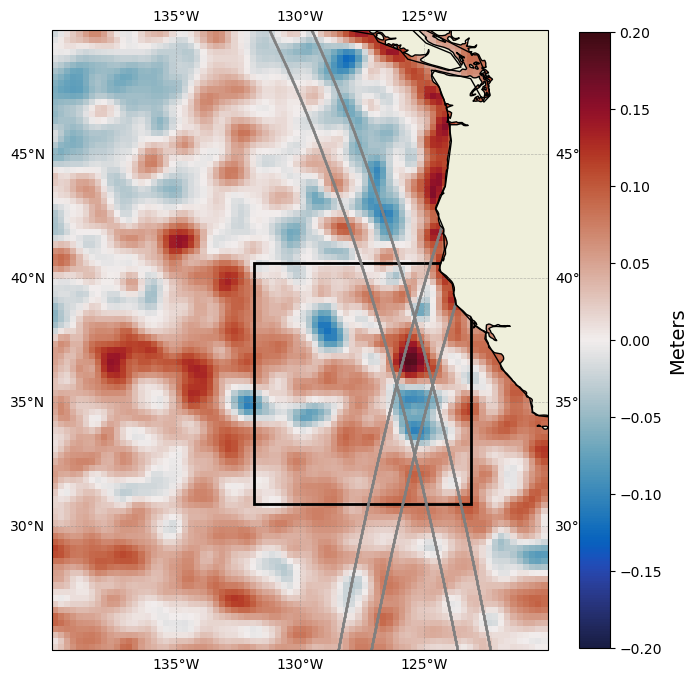

In [26]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import cmocean as cmo  # Assuming cmocean is used for colormap
import matplotlib.ticker as mticker


# Assuming 'swot_ds' and 'avisso_ds' are your datasets, and 'date_time' holds date information

# Extracting positions and dimensions for mapping
latitude_nadir = swot_ds['latitude_nadir'].values
longitude_nadir = swot_ds['longitude_nadir'].values
latitude = swot_ds['latitude'].values
longitude = swot_ds['longitude'].values

# Calculating rectangle boundaries for highlighting an area
lon, lat = (360 - avisso_ds.lon[lonidx_west:lonidx_east].data) * -1, avisso_ds.lat[latidx_south:latidx_north].data
left, bottom, width, height = lon[0], lat[0], lon[-1] - lon[0], lat[-1] - lat[0]

# Initialize the plot
plt.figure(figsize=(8, 10))
ax = plt.axes(projection=ccrs.PlateCarree())  # Use PlateCarree projection for geographic data
ax.set_extent([-140, -120, 25, 50], crs=ccrs.PlateCarree())  # Focus on the California Current region

# Plotting SSH Anomalies
ssh_anomalies = plt.pcolor((360 - avisso_ds.lon[30:140]) * -1, avisso_ds.lat, SSHA0[:, 30:140], vmin=-0.2, vmax=0.2, cmap=cmo.cm.balance)
cbar = plt.colorbar(ssh_anomalies, shrink = 0.8)  # Add colorbar for SSH anomalies
cbar.set_label('Meters', fontsize=14)  # Label for the colorbar

# Add a rectangle to highlight a specific area
rect = mpatches.Rectangle((left, bottom), width, height, fill=False, color="black", linewidth=2)
ax.add_patch(rect)

# Plotting satellite ground tracks
ax.plot(longitude[:, 0], latitude[:, -1], '.-', color='gray', markersize=1, linewidth=0.5, transform=ccrs.Geodetic())
ax.plot(longitude[:, -1], latitude[:, 0], '.-', color='gray', markersize=1, linewidth=0.5, transform=ccrs.Geodetic())

# Enhance map with features
ax.coastlines(resolution='110m', zorder=3)  # Draw coastlines on top of the data
ax.add_feature(cfeature.LAND, edgecolor='black', zorder=2)  # Add land feature

# Map enhancements
# ax.gridlines(draw_labels=True)  # Add gridlines with labels
# Customize gridlines with 5-degree intervals
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xlocator = mticker.MultipleLocator(5)  # Set longitude intervals to 5 degrees
gl.ylocator = mticker.MultipleLocator(5)  # Set latitude intervals to 5 degrees

plt.xlabel('Longitude (°W)', fontsize=14)  # Longitude label
plt.ylabel('Latitude (°N)', fontsize=14)  # Latitude label

# Save the plot to a file
plt.savefig(f'SWOT_groundtrack{str(date_time[0])[:10]}.png')
plt.show()  # Display the plot
